In [18]:
import pandas as pd
import numpy as np

import pickle

import holidays

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [12]:
#Please download data and change the path
data_jan = pd.read_parquet("data/green_tripdata_2021-01.parquet")
data_feb = pd.read_parquet("data/green_tripdata_2021-02.parquet")

In [13]:
pd.to_datetime('2021-01-01 00:15:56')

Timestamp('2021-01-01 00:15:56')

In [14]:
data_jan

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,0.50,0.5,0.00,0.00,NaN,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,0.50,0.5,2.81,0.00,NaN,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,0.50,0.5,1.00,0.00,NaN,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,0.50,0.5,0.00,0.00,NaN,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.00,0.00,-0.5,0.00,0.00,NaN,-0.3,-52.80,3.0,1.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,2.75,0.0,0.00,6.12,NaN,0.3,65.40,NaN,NaN,NaN
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,0.00,0.0,12.20,6.12,NaN,0.3,65.28,NaN,NaN,NaN
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,2.75,0.0,0.00,0.00,NaN,0.3,22.00,NaN,NaN,NaN
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,2.75,0.0,0.00,6.12,NaN,0.3,58.04,NaN,NaN,NaN


In [15]:
def process_data(data, floor=True):
    data = data.copy()
    data['time'] = data.lpep_dropoff_datetime - data.lpep_pickup_datetime
    if floor: #Floor or not Floor, the data is skewed. Check next cell.
        data['time_minutes'] = np.floor(data.time.dt.total_seconds() / 60 )
    else:
        data['time_minutes'] = data.time.dt.total_seconds() / 60 
    
    data = data.loc[data.time_minutes >= 4].loc[data.time_minutes <= 60] #I've used 4 minutes as the cutoff as it appears the distribution
                                                                         #is Highly erroneous for any time less than that. Could also bundle all times
                                                                         #less than 5 minutes under one label.

    
    us_holidays = holidays.US()
    data['date'] = data.lpep_dropoff_datetime.dt.date
    data['holiday'] = data.date.apply(lambda date: us_holidays.get(date)) #Get holidays for each date.
    
    data['dayofweek'] = data.lpep_dropoff_datetime.dt.dayofweek
    data['departure_hour'] = data.lpep_dropoff_datetime.dt.hour
    
    data.drop(data.columns.difference(['time_minutes','trip_distance', 'PULocationID','DOLocationID', 'holiday', 'dayofweek', 'departure_hour']), axis=1, inplace=True)
    
    data['holiday_bin'] = data.holiday != 'None' #Treat all holidays the same. Necessary as our datasets are within 2 different months.
                                                 #A better analysis would involve the entire year.
    data.drop('holiday', axis=1, inplace=True)
    
    categorical = ['PULocationID','DOLocationID', 'holiday_bin', 'dayofweek', 'departure_hour']
    numerical =['trip_distance']

    data[categorical] = data[categorical].astype('str')
    data['PU_DO'] = data.PULocationID + data.DOLocationID
    
    categorical = ['PU_DO', 'PULocationID', 'DOLocationID', 'holiday_bin', 'dayofweek', 'departure_hour']
    data_dict = data[categorical + numerical].to_dict(orient='records')
    
    return data, data_dict, data['time_minutes']

Text(0.5, 1.0, 'Floored')

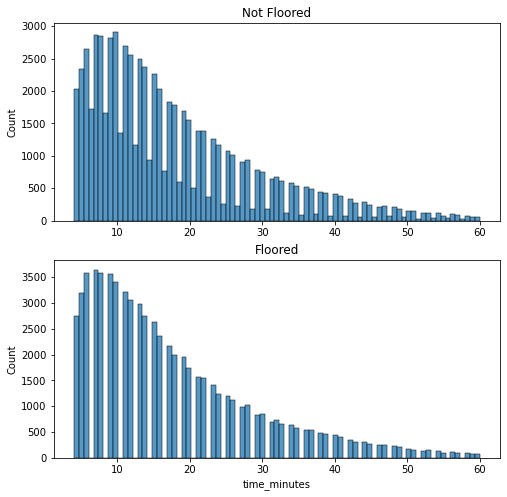

In [58]:
data_floor, _, _ = process_data(data_jan, floor=False)
data_notfloor, _, _ = process_data(data_jan)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8,8))
sns.histplot(data_floor.time_minutes, ax=ax1)
ax1.set_title("Not Floored")
ax1.set_xlabel("")
sns.histplot(data_notfloor.time_minutes, ax=ax2)
ax2.set_title("Floored")

In [59]:
#Here are the train and prediction functions standalone. Which I've bundled into a class with more options in the next cell.
def train(train_dict, y_train):
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_dict)
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    return dv, lr
def predict(dv, lr, test_dict):
    X_test = dv.transform(test_dict)
    return np.round(lr.predict(X_test))

    return np.exp(lr.predict(X_test))
    

In [16]:
class TimePredictionModel: #Class containing all our model.
    def __init__(self, model=LinearRegression(), transform=None, reverse_transform=None, round_=False):
        self.model = model
        self.transform = transform #Transform function, could be log for example
        self.reverse_transform = reverse_transform #Reverse Transform, Both Transform and Reverse Transform MUST be defined to transform the data.
        self.dictvectorizer = DictVectorizer()
        
        self.model_trained = False
        self.round = round_ #Whether to round the result or not. I've found that the data is highly skewed towards whole minute
    def fit(self, train_dict, y_train):
        assert  not self.model_trained, "Model already trained"
            
        X_train = self.dictvectorizer.fit_transform(train_dict)
        
        if self.transform == None or self.reverse_transform == None:
            self.model.fit(X_train, y_train)
        else:
            self.model.fit(X_train, self.transform(y_train))
        self.model_trained = True
        
    def predict(self, test_dict):
        assert self.model_trained, "Model Not yet trained, train with model.fit"
        X_test = self.dictvectorizer.transform(test_dict)
        
        if self.transform == None or self.reverse_transform == None:
            if self.round:
                return np.round(self.model.predict(X_test))
            else:
                return self.model.predict(X_test)
        else:
            if self.round:
                return np.round(self.reverse_transform(self.model.fit(X_test)))
            else:
                return self.reverse_transform(self.model.fit(X_test))
        
    def transform(self, test_dict):
        assert self.model_trained, "Model Not yet trained, train with model.fit"
        
        return self.dictvectorizer.transform(test_dict)
        

In [19]:
_, train_dict, y_train = process_data(data_jan)

Model = TimePredictionModel(round_=True)
Model.fit(train_dict, y_train)

y_pred = Model.predict(train_dict)

mean_squared_error(y_train, y_pred, squared=False)

4.532126350189418

In [20]:
#fig, ax = plt.subplots(figsize=(8,8))
#sns.histplot(y_pred, ax=ax, stat='density', kde=True, label="Predicted distribution", legend=True)
#sns.histplot(y_train, ax=ax, color='orange', alpha=0.3, stat='density', kde=True, label="True distribution")

NameError: name 'plt' is not defined

In [21]:
_, test_dict, y_test = process_data(data_feb)

y_pred = Model.predict(test_dict)

mean_squared_error(y_pred, y_test, squared=False)

7.4078598637277295

In [22]:
with open("models/linreg.bin", 'wb') as f_out:
    pickle.dump(Model, f_out)
    

In [25]:
with open("models/linreg.bin", 'rb') as f_in:
    Model =  pickle.load(f_in)

In [27]:
Model.predict(test_dict)

array([10.,  8., 10., ...,  9.,  3.,  3.])